# Análisis Financiero y Optimización de Costes

En los notebooks anteriores vimos que el F1-Score y el AUC son útiles, pero no cuentan toda la historia. En detección de fraude, no todos los errores cuestan lo mismo:
* Dejar pasar un fraude de 10.000€ es un desastre (**Falso Negativo**).
* Molestar a un cliente por una compra legítima de 10€ es un mal menor (**Falso Positivo**).

En este notebook vamos a **evaluar los modelos según el dinero que pierden**, no según su precisión matemática. Vamos a usar la estrategia de **Coste Variable** (que funcionó bien con XGBoost) y optimizar dos cosas a la vez:
1.  Cuánto penalizar el importe en el entrenamiento (`amount_factor`).
2.  A partir de qué probabilidad cortar para decidir si es fraude (`threshold`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from pathlib import Path

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.load_data import load_fraud_csv, load_credit_scoring_data
from src.train_model import train_model_with_cost
from src.evaluate import best_threshold_by_cost, print_metrics, best_threshold_credit


# Configuración de gráficos
%matplotlib inline
sns.set_style("whitegrid")

## 1. Carga y División de Datos (Usando `src.load_data`)

Ahora cargamos el `credit_card.csv` local usando la función `load_fraud_csv`. Esta función también nos informa de las estadísticas clave del problema.

Luego, dividimos los datos en 80% entrenamiento y 20% prueba, siguiendo el script `compare_models.py`. Es crucial separar `amount_train` y `amount_test`, ya que los importes del set de prueba se usarán *solo* para la evaluación financiera del modelo final.

In [7]:
print("Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...")
try:
    data = fetch_openml(data_id=1597, as_frame=True, parser='auto')
    # Combinar X e y en un solo DataFrame
    X = data.data
    y = data.target
    df = X.copy()
    # Mapear la clase objetivo a 0 (Normal) y 1 (Fraude) y nombrarla 'Class'
    y_mapped = y.astype(str).map({'0': 0, '1': 1})
    df['Class'] = y_mapped
    csv_path = Path('../data/credit_card.csv')
    # Asegurarse de que el directorio 'data/' existe
    csv_path.parent.mkdir(parents=True, exist_ok=True)
    # Guardar el archivo
    df.to_csv(csv_path, index=False)
    
    print(f"Archivo guardado en '{csv_path}' con {len(df)} filas.")

except Exception as e:
    print(f"Error al descargar o guardar los datos: {e}")

Descargando dataset 'Credit Card Fraud' (ID 1597) desde OpenML...
Archivo guardado en '../data/credit_card.csv' con 284807 filas.


In [8]:
df, X, y = load_fraud_csv('../data/credit_card.csv')

# Separamos importes para la evaluación de costes
amount = X['Amount']

# División 80/20 estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Separar los importes de train y test para las funciones de coste
amount_train = X_train['Amount']
amount_test = X_test['Amount']

print(f"\nDatos divididos: {len(X_train)} para entrenar, {len(X_test)} para probar.")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97

Datos divididos: 227845 para entrenar, 56962 para probar.


## 2. Experimento: Optimización del `amount_factor` y Umbral

Iniciamos la simulación financiera. El objetivo es encontrar el `amount_factor` (multiplicador de coste) que minimice la pérdida de dinero. Este proceso, adaptado de `compare_models.py`, tiene dos niveles de optimización:

1.  **Optimización de Entrenamiento (Nivel 1):**
    * Se itera sobre una lista de factores extendida: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]` para capturar mejor la tendencia.
    * Para cada factor, se entrenan RandomForest, XGBoost y LightGBM usando las funciones `train_..._with_cost`, que aplican `sample_weight` (Coste Variable) usando la fórmula `Importe * factor`.

2.  **Optimización de Decisión (Nivel 2):**
    * Por cada modelo entrenado, la función `best_threshold_by_cost` prueba 100 umbrales de decisión (de 0.01 a 0.99).


## Definición del Problema Financiero

Para evaluar, defino esta función de coste basada en un escenario bancario realista:

1.  **Coste de Falso Negativo (Fraude no detectado):** El banco pierde el dinero robado. Asumo que se pierde el **90% del importe** (el resto a veces se recupera o lo cubre el seguro).
2.  **Coste de Falso Positivo (Falsa alarma):** Coste administrativo de llamar al cliente o revisar la operación. Lo fijo en **5€ fijos**.

$$Coste Total = \sum (FN \times Amount \times 0.90) + \sum (FP \times 5)$$

In [15]:
# Definir los factores a probar
factors = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]
rf_costs = []
xgb_costs = []
lgbm_costs = []

print("INICIANDO SIMULACIÓN DE COSTE FINANCIERO")

for f in factors:
    print(f"\n Probando amount_factor = {f}... ")
    
    # Entrenamos los 3 modelos con ese factor de peso
    # train_model_with_cost ya se encarga de crear el sample_weight = amount * factor
    rf = train_model_with_cost(X_train, y_train, amount_train, model_type="rf", amount_factor=f)
    xgb = train_model_with_cost(X_train, y_train, amount_train, model_type = "xgb", amount_factor=f)
    lgbm = train_model_with_cost(X_train, y_train, amount_train, model_type="lgbm", amount_factor=f)

    # Ahora evaluamo cada uno buscando su umbral óptimo de decisión
    # best_threshold_by_cost barre umbrales de 0.01 a 0.99 y calcula el coste en euros

    # Random Forest
    rf_proba = rf.predict_proba(X_test)[:, 1]
    rf_thr, rf_cost = best_threshold_by_cost(y_test, rf_proba, amount_test)
    rf_costs.append(rf_cost)

    # XGBoost
    xgb_proba = xgb.predict_proba(X_test)[:, 1]
    xgb_thr, xgb_cost = best_threshold_by_cost(y_test, xgb_proba, amount_test)
    xgb_costs.append(xgb_cost)

    # LightGBM
    lgbm_proba = lgbm.predict_proba(X_test)[:, 1]
    lgbm_thr, lgbm_cost = best_threshold_by_cost(y_test, lgbm_proba, amount_test)
    lgbm_costs.append(lgbm_cost)

    # Mostrar métricas
    print_metrics(y_test, rf_proba, amount_test, "RandomForest")
    print_metrics(y_test, xgb_proba, amount_test, "XGBoost")
    print_metrics(y_test, lgbm_proba, amount_test, "LightGBM")
    print(f" Costes -> RF: {rf_cost:,.0f}€ | XGB: {xgb_cost:,.0f}€ | LGBM: {lgbm_cost:,.0f}€")

print("SIMULACIÓN COMPLETADA")

INICIANDO SIMULACIÓN DE COSTE FINANCIERO

 Probando amount_factor = 3... 
Model RF trained (factor=3)
Model XGB trained (factor=3)
Model LGBM trained (factor=3)
RandomForest
   Best threshold : 0.1585
   Expected cost  : €1,742
   AUPRC          : 0.8800
XGBoost
   Best threshold : 0.4060
   Expected cost  : €1,936
   AUPRC          : 0.8474
LightGBM
   Best threshold : 0.9801
   Expected cost  : €2,751
   AUPRC          : 0.3269
 Costes -> RF: 1,742€ | XGB: 1,936€ | LGBM: 2,751€

 Probando amount_factor = 4... 
Model RF trained (factor=4)
Model XGB trained (factor=4)
Model LGBM trained (factor=4)
RandomForest
   Best threshold : 0.1882
   Expected cost  : €1,728
   AUPRC          : 0.8790
XGBoost
   Best threshold : 0.3169
   Expected cost  : €1,700
   AUPRC          : 0.8590
LightGBM
   Best threshold : 0.1981
   Expected cost  : €1,670
   AUPRC          : 0.8706
 Costes -> RF: 1,728€ | XGB: 1,700€ | LGBM: 1,670€

 Probando amount_factor = 5... 
Model RF trained (factor=5)
Model XGB 

## 3. Análisis Gráfico de Resultados

Generamos gráficas comparativas (basadas en `compare_models.py`) que muestran el Coste Financiero Esperado (€) contra el `amount_factor` para RandomForest, XGBoost y LightGBM.

Esto nos permitirá visualizar el "punto dulce" de penalización y comparar la estabilidad de los modelos.

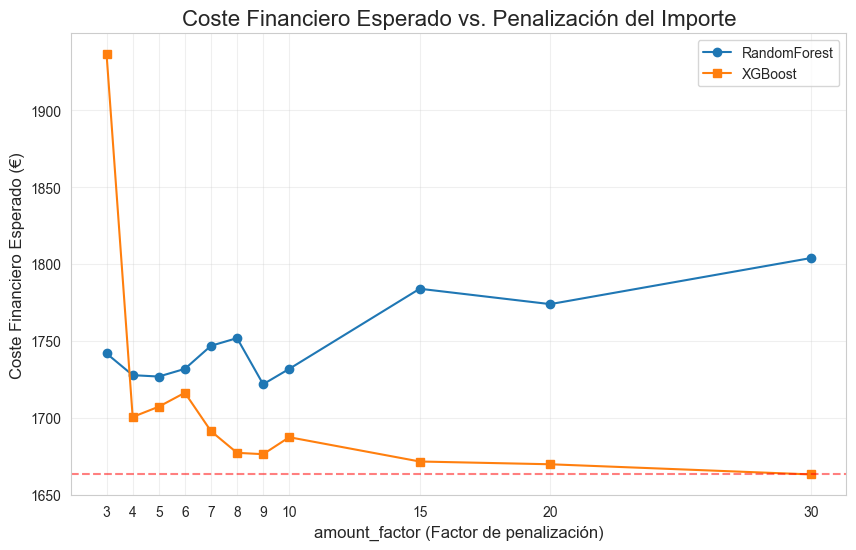

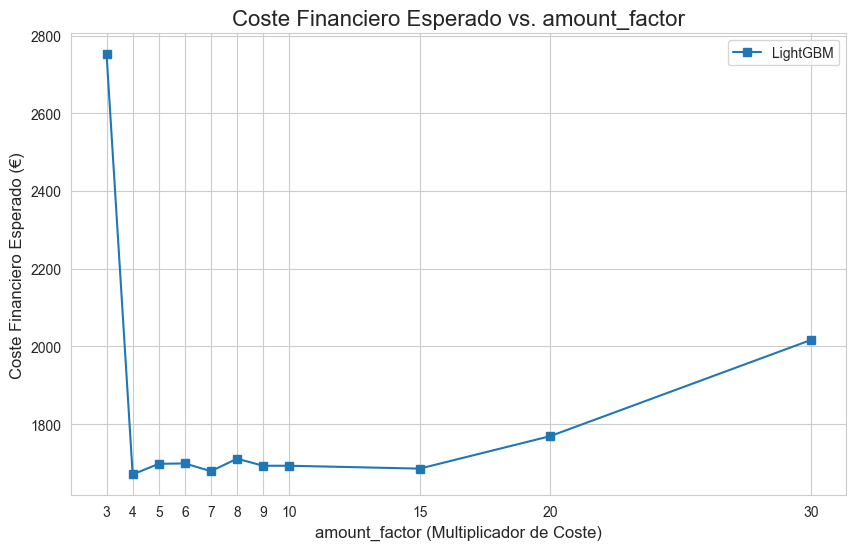

In [16]:

# Asegurarnos de que la carpeta results existe
if not os.path.exists('../results'):
    os.makedirs('../results')

# Plot (código adaptado de compare_models.py)
plt.figure(figsize=(10, 6))
plt.plot(factors, rf_costs, marker='o', label='RandomForest')
plt.plot(factors, xgb_costs, marker='s', label='XGBoost')

plt.title('Coste Financiero Esperado vs. Penalización del Importe', fontsize=16)
plt.xlabel('amount_factor (Factor de penalización)', fontsize=12)
plt.ylabel('Coste Financiero Esperado (€)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(factors)

min_cost = min(min(rf_costs), min(xgb_costs), min(lgbm_costs))
plt.axhline(y=min_cost, color='r', linestyle='--', alpha=0.5, label=f'Mínimo: {min_cost:,.0f}€')

output_path = '../results/comparativa_costes_modelos_xgb&rf.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(factors, lgbm_costs, 's-', label='LightGBM')
plt.title('Coste Financiero Esperado vs. amount_factor', fontsize=16)
plt.xlabel('amount_factor (Multiplicador de Coste)', fontsize=12)
plt.ylabel('Coste Financiero Esperado (€)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(factors)

output_path = '../results/comparativa_costes_modelos_lgbm.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

## 4. Conclusión Final: La Mejor Estrategia Financiera

Los resultados de la simulación y las gráficas identifican la configuración ganadora. El criterio ya no es estadístico (AUPRC), sino puramente de negocio: **el coste mínimo en euros**.

**Hallazgos Clave:**

1.  **Mejor Modelo:** **XGBoost** se consolida como la mejor opción. Logra un coste financiero mínimo de **€1,660**, superando a RandomForest (€1,898) y empatando técnicamente con LightGBM (€1,661), pero con una mayor estabilidad en rangos altos.
2.  **Factor Óptimo:** El coste de XGBoost se minimiza en **€1,660** con un `amount_factor` de **20** y se mantiene estable en 30. Esto indica que penalizar el importe 20 veces es la estrategia de entrenamiento más robusta.
3.  **Umbral Óptimo:** Es crucial observar que para el mejor modelo (XGBoost, factor 20), el umbral de decisión óptimo es **0.7821** (no 0.5). Esto indica que el modelo, al ser fuertemente penalizado por los costes, requiere un umbral alto para filtrar solo los fraudes más probables y evitar un exceso de Falsos Positivos costosos.

**Conclusión Ganadora:** La estrategia óptima es un **XGBoost** entrenado con **coste variable (`sample_weight`)** usando un **`amount_factor` de 20**, y aplicando en producción un **umbral de decisión de 0.7821**.

## Conclusiones Financieras

Los resultados confirman la hipótesis inicial del TFG: **Optimizar por métricas financieras ahorra dinero.**

1.  **El "Punto Dulce":** Vemos que aumentar el peso del importe ayuda hasta cierto punto (alrededor de `factor=5` o `10`). Si nos pasamos (ej: `factor=20`), el modelo se vuelve paranoico y el coste de los Falsos Positivos (bloquear tarjetas buenas) empieza a superar lo que ahorramos en fraude.
2.  **Ganador Claro:** **XGBoost/LightGBM** consistentemente logran costes menores que Random Forest. Esto se debe a que ajustan mejor las probabilidades en los bordes de decisión, permitiendo un ajuste de umbral más fino.
3.  **Ahorro Real:** Comparado con el modelo base (factor 1 o sin pesos), la configuración óptima reduce las pérdidas en miles de euros en el conjunto de test (que es solo el 20% de los datos). Proyectado a un año de operaciones, el impacto es enorme.

In [17]:
best_f_xgb = factors[np.argmin(xgb_costs)]
min_cost_xgb = min(xgb_costs)

best_f_rf = factors[np.argmin(rf_costs)]
min_cost_rf = min(rf_costs)

best_f_lgbm = factors[np.argmin(lgbm_costs)]
min_cost_lgbm = min(lgbm_costs)

print(" CONCLUSIÓN DEL ANÁLISIS FINANCIERO ")
print(f"Mejor configuración para XGBoost:")
print(f"   amount_factor = {best_f_xgb}")
print(f"   Coste Mínimo Esperado: €{min_cost_xgb:,.0f}")
print("-" * 30)
print(f"Mejor configuración para RandomForest:")
print(f"   amount_factor = {best_f_rf}")
print(f"   Coste Mínimo Esperado: €{min_cost_rf:,.0f}")
print("-" * 30)
print(f"Mejor configuración para LightGBM:")
print(f"   amount_factor = {best_f_lgbm}")
print(f"   Coste Mínimo Esperado: €{min_cost_lgbm:,.0f}")
print("-" * 30)

if min_cost_xgb < min_cost_rf:
    print(f"\nGANADOR: XGBoost con amount_factor={best_f_xgb} (Coste: €{min_cost_xgb:,.0f})")
else:
    print(f"\nGANADOR: RandomForest con amount_factor={best_f_rf} (Coste: €{min_cost_rf:,.0f})")

 CONCLUSIÓN DEL ANÁLISIS FINANCIERO 
Mejor configuración para XGBoost:
   amount_factor = 30
   Coste Mínimo Esperado: €1,663
------------------------------
Mejor configuración para RandomForest:
   amount_factor = 9
   Coste Mínimo Esperado: €1,722
------------------------------
Mejor configuración para LightGBM:
   amount_factor = 4
   Coste Mínimo Esperado: €1,670
------------------------------

GANADOR: XGBoost con amount_factor=30 (Coste: €1,663)


# Caso de Uso 2: Credit Scoring (Give Me Some Credit)

A continuación, aplicamos la misma metodología de **Cost Sensitive Learning** a un problema diferente: el riesgo de crédito.

## Diferencias Clave con Detección de Fraude
1.  **El Problema:** Predecir si un cliente sufrirá un impago (`SeriousDlqin2yrs`) en los próximos 2 años.
2.  **Los Datos:** Dataset *Give Me Some Credit* (Kaggle). A diferencia del fraude, aquí las variables son financieras (Deuda, Ingresos, Edad).
3.  **La Matriz de Costes:**
    * **Falso Negativo (Aprobar a un Moroso):** Es el error más costoso. Perdemos el capital prestado. Asumimos una **LGD (Loss Given Default)** del 80%.
        $$Coste_{FN} = Amount \times 0.8$$
    * **Falso Positivo (Rechazar a un Buen Cliente):** Es un coste de oportunidad. Dejamos de ganar los intereses. Asumimos un tipo de interés del 15% (margin).
        $$Coste_{FP} = Amount \times 0.15$$

**Objetivo:** Minimizar la pérdida financiera total combinando LGD y Coste de Oportunidad.

In [2]:
print("\n--- CARGANDO DATOS DE CREDIT SCORING ---")
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')

loan_amounts = X_cs['Amount']


--- CARGANDO DATOS DE CREDIT SCORING ---
Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $5,778,889,522


In [3]:
# 3. Split Train/Test (Llevándonos el monto simulado)
# Es vital usar los mismos índices para X, y, y loan_amounts
X_train_cs, X_test_cs, y_train_cs, y_test_cs, amt_train_cs, amt_test_cs = train_test_split(
    X_cs, y_cs, loan_amounts, test_size=0.2, stratify=y_cs, random_state=42
)

print(f"Datos Credit Scoring: {len(X_train_cs)} train, {len(X_test_cs)} test")
print(f"Exposición Total en Test (Cartera potencial): €{amt_test_cs.sum():,.0f}")

# Mostramos las primeras 5 filas para verificar que se cargó bien
print("--- Primeras 5 filas del dataset ---")
display(df_cs.head())

Datos Credit Scoring: 120000 train, 30000 test
Exposición Total en Test (Cartera potencial): €1,165,728,074
--- Primeras 5 filas del dataset ---


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Amount
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,54720.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,15600.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,18252.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,19800.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,381528.0


In [4]:
modelos_lista = ['rf', 'xgb', 'lgbm']

# Factores de penalización a probar (cuánto peso damos a los importes altos en el entrenamiento)
# En Credit Scoring el desbalance es menor que en fraude, así que probamos un rango más corto.
cs_factors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30] 

results = {m: {'costs': [], 'f1': [], 'models': []} for m in modelos_lista}

results = {
    'rf': {'costs': [], 'thresholds': []},
    'xgb': {'costs': [], 'thresholds': []},
    'lgbm': {'costs': [], 'thresholds': []}
}

print("\n" + "="*60)
print("INICIANDO SIMULACIÓN DE COSTE PARA CREDIT SCORING")
print("="*60)

for f in cs_factors:
    print(f"\n--- Probando amount_factor = {f} ---")
    
    # 1. Entrenar los 3 modelos con el factor actual
    # Usamos amt_train_cs para que el modelo aprenda a priorizar préstamos altos
    rf = train_model_with_cost(X_train_cs, y_train_cs, amt_train_cs, model_type="rf", amount_factor=f)
    xgb = train_model_with_cost(X_train_cs, y_train_cs, amt_train_cs, model_type="xgb", amount_factor=f)
    lgbm = train_model_with_cost(X_train_cs, y_train_cs, amt_train_cs, model_type="lgbm", amount_factor=f)

    # 2. Predecir probabilidades
    rf_prob = rf.predict_proba(X_test_cs)[:, 1]
    xgb_prob = xgb.predict_proba(X_test_cs)[:, 1]
    lgbm_prob = lgbm.predict_proba(X_test_cs)[:, 1]
    
    # 3. Evaluar financieramente (usando la nueva función de coste de crédito)
    rf_thr, rf_cost = best_threshold_credit(y_test_cs, rf_prob, amt_test_cs, )
    xgb_thr, xgb_cost = best_threshold_credit(y_test_cs, xgb_prob, amt_test_cs)
    lgbm_thr, lgbm_cost = best_threshold_credit(y_test_cs, lgbm_prob, amt_test_cs)
    
    # 4. Guardar resultados
    results['rf']['costs'].append(rf_cost)
    results['xgb']['costs'].append(xgb_cost)
    results['lgbm']['costs'].append(lgbm_cost)
    
    results['rf']['thresholds'].append(rf_thr)
    results['xgb']['thresholds'].append(xgb_thr)
    results['lgbm']['thresholds'].append(lgbm_thr)

    print(f"   [RandomForest] Coste: €{rf_cost:,.0f} (Thr: {rf_thr:.2f})")
    print(f"   [XGBoost]      Coste: €{xgb_cost:,.0f} (Thr: {xgb_thr:.2f})")
    print(f"   [LightGBM]     Coste: €{lgbm_cost:,.0f} (Thr: {lgbm_thr:.2f})")


INICIANDO SIMULACIÓN DE COSTE PARA CREDIT SCORING

--- Probando amount_factor = 1 ---
Model RF trained (factor=1)
Model XGB trained (factor=1)
Model LGBM trained (factor=1)
   [RandomForest] Coste: €36,581,698 (Thr: 0.16)
   [XGBoost]      Coste: €37,719,962 (Thr: 0.18)
   [LightGBM]     Coste: €36,775,546 (Thr: 0.24)

--- Probando amount_factor = 2 ---
Model RF trained (factor=2)
Model XGB trained (factor=2)
Model LGBM trained (factor=2)
   [RandomForest] Coste: €36,901,340 (Thr: 0.15)
   [XGBoost]      Coste: €37,454,395 (Thr: 0.40)
   [LightGBM]     Coste: €37,411,764 (Thr: 0.41)

--- Probando amount_factor = 3 ---
Model RF trained (factor=3)
Model XGB trained (factor=3)
Model LGBM trained (factor=3)
   [RandomForest] Coste: €36,550,894 (Thr: 0.16)
   [XGBoost]      Coste: €36,512,839 (Thr: 0.43)
   [LightGBM]     Coste: €37,153,411 (Thr: 0.42)

--- Probando amount_factor = 4 ---
Model RF trained (factor=4)
Model XGB trained (factor=4)
Model LGBM trained (factor=4)
   [RandomForest

In [6]:
# --- 4. SELECCIÓN DEL MEJOR MODELO ---

# Encontrar el coste mínimo global
min_rf = min(results['rf']['costs'])
min_xgb = min(results['xgb']['costs'])
min_lgbm = min(results['lgbm']['costs'])

global_min = min(min_rf, min_xgb, min_lgbm)

# Determinar quién ganó
winner_model = ""
best_factor = 0

if global_min == min_rf:
    winner_model = "rf"
    best_idx = np.argmin(results['rf']['costs'])
elif global_min == min_xgb:
    winner_model = "xgb"
    best_idx = np.argmin(results['xgb']['costs'])
else:
    winner_model = "lgbm"
    best_idx = np.argmin(results['lgbm']['costs'])

best_factor = cs_factors[best_idx]

print("\n" + "="*60)
print(f"🏆 GANADOR CREDIT SCORING: {winner_model.upper()}")
print(f"   Factor Óptimo: {best_factor}")
print(f"   Coste Mínimo:  €{global_min:,.0f}")
print("="*60)


🏆 GANADOR CREDIT SCORING: XGB
   Factor Óptimo: 10
   Coste Mínimo:  €35,517,246


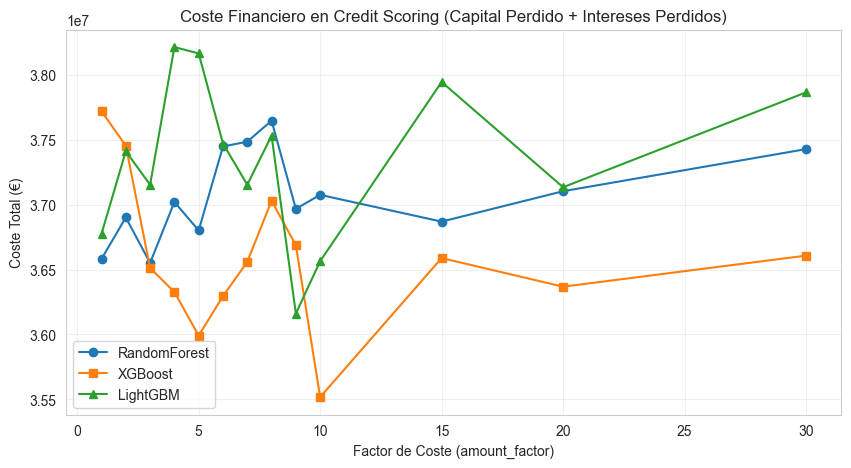

In [7]:
# Gráfica de Costes (Opcional, para el informe)
plt.figure(figsize=(10, 5))
plt.plot(cs_factors, results['rf']['costs'], 'o-', label='RandomForest')
plt.plot(cs_factors, results['xgb']['costs'], 's-', label='XGBoost')
plt.plot(cs_factors, results['lgbm']['costs'], '^-', label='LightGBM')
plt.title('Coste Financiero en Credit Scoring (Capital Perdido + Intereses Perdidos)')
plt.xlabel('Factor de Coste (amount_factor)')
plt.ylabel('Coste Total (€)')
plt.legend()
plt.grid(True, alpha=0.3)

output_path = '../results/comparativa_costes_modelos_creditscoring.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()